In [2]:
class ProteinsDataset(torch.utils.data.Dataset):
    
    # Encoding

    AMINOACIDS = 'ACDEFGHIKLMNPQRSTVWY'

    default_dna_encoding = {'A': (0, 0), 'C': (0, 1), 'G': (1, 0), 'T': (1, 1)}

    default_amino_encoding = {aminoacid: tuple(int(bit) for bit in f"{index:05b}")
                              for index, aminoacid in enumerate(AMINOACIDS)}
    
    default_encodings = {'seq': default_dna_encoding,
                         'protein': default_amino_encoding}
    
    
    def __init__(self, fields_column, target_column='energy', encoding=None):
        
        self.fields_column = fields_column
        self.target_column = target_column
        
        self.encoding = encoding or self.default_encodings[fields_column]
            
        self.decoding = {bits: symbol for symbol, bits in self.encoding.items()}

        self.bits_per_symbol = len(list(self.encoding.values())[0])
               
        self.fields = None
        self.targets = np.array([])        
        self.data = pd.DataFrame()
        
    
    def extend(self, dataset_path):        
        
        data = pd.read_csv(dataset_path, index_col=0)
        
        column_mapping = self.unify_column_names(data.columns)
        
        data.rename(columns=column_mapping, inplace=True)
        
        
        # Fields
        
        field_series = data[self.fields_column]
        
        field_bits_count = len(field_series[0]) * self.bits_per_symbol
        
        if self.fields is None:            
            self.fields = np.array([]).reshape(0, field_bits_count).astype(int)
        
        new_fields = np.vstack(field_series.apply(self.encode))
        new_targets = data[self.target_column].to_numpy()
        
        self.fields = np.vstack([self.fields, new_fields])
        self.targets = np.concatenate([self.targets, new_targets])
        
        self.data = pd.concat([self.data, data])
        
        
        # Dimensions
        
        self.field_dimensions = np.max(self.fields, axis=0).astype(int) + 1
        
        self.field_dimensions[self.field_dimensions < 2] = 2
        
    
    def unify_column_names(self, column_names):
        
        new_column_names = []
        
        for column_name in column_names:
                        
            if '_' in column_name:
                
                column_name_parts = column_name.split('_')
                
                new_column_name = '_'.join(column_name_parts[1:])
                
            else:
                
                new_column_name = column_name
                
            new_column_names.append(new_column_name)
        
        column_mapping = dict(zip(column_names, new_column_names))
        
        return column_mapping
    
    
    def encode(self, symbols):
        
        # binary = [bit for nucleotide in dna_sequence 
        #           for bit in self.dna_encoding[nucleotide]]
        
        bits = []

        for symbol in symbols:

            bits.extend(self.encoding[symbol])

        return bits
    
    
    def decode(self, bits):
        
        symbols = ''
        
        # bit_chunks = zip(bits[0::2], bits[1::2])
        
        bit_chunks = np.array(bits).reshape(-1, self.bits_per_symbol)
        
        for bit_chunk in bit_chunks:
        
            symbols += self.decoding.get(tuple(bit_chunk), 'X')
            
        return symbols
        
        
    def save(self, file_path):
        
        self.data.to_csv(file_path, index=False)
        
    
    def __len__(self):
        
        return self.fields.shape[0]
    

    def __getitem__(self, index):
        
        fields = self.fields[index]
        target = self.targets[index].squeeze()
        
        return fields, target
    
    
    def append_records(self, new_fields, new_targets, record_repetitions_count):
        
        new_rows_count = new_fields.shape[0] * record_repetitions_count
    
        new_fields_array = np.tile(new_fields, (record_repetitions_count, 1))
        new_targets_array = np.tile(new_targets, (record_repetitions_count, 1)).ravel()

        self.fields = np.vstack((self.fields, new_fields_array))
        self.targets = np.concatenate((self.targets, new_targets_array))
        
        # TODO: append to self.data

In [3]:
# FIELDS_COLUMN = 'seq'
FIELDS_COLUMN = 'protein'

dataset = ProteinsDataset(fields_column=FIELDS_COLUMN)

dataset.extend('datasets/f100.csv')
dataset.extend('datasets/f100r.csv')
dataset.extend('datasets/m1.csv')
dataset.extend('datasets/m1r.csv')
# # dataset.extend('datasets/pilot_x1.csv')
# # dataset.extend('datasets/pilot_x1r.csv')
dataset.extend('datasets/x1.csv')
dataset.extend('datasets/x1r.csv')
dataset.extend('datasets/x100.csv')
dataset.extend('datasets/x100r.csv')

dataset.fields.shape, dataset.targets.shape

((21594, 110), (21594,))

In [4]:
# dataset.save('datasets/combined_dataset.csv')

In [5]:
def decode_sampling_results(sampling_results):

    results = []

    for sampling_result in sampling_results.data():

        samples = np.array(list(sampling_result.sample.values()))
        
        bits = qubo.one_hot_to_bits(samples)
        
        symbols = dataset.decode(bits)
        
        decimal = sum(number * 2 ** position for position, number in enumerate(reversed(bits)))

        result = {'decimal': np.array(decimal),
                  'samples': samples,
                  'bits': bits,
                  'symbols': symbols,
                  'qubo_energy': sampling_result.energy,
                  'num_occurrences': sampling_result.num_occurrences}
        
        results.append(result)

    results = pd.DataFrame(results)
    
    bits = np.vstack(results['bits'])
    
    target_binding_energies = target_regressor.predict(bits)
    
    offtarget_binding_energies = [offtarget_regressor.predict(bits) 
                                  for offtarget_regressor in offtarget_regressors]
    
    results['target_binding_energy'] = target_binding_energies
    results['offtarget_binding_energy'] = np.vstack(offtarget_binding_energies).sum(axis=0)
    results['offtarget_binding_energy'] = results['offtarget_binding_energy'] / len(offtarget_proteins)
    
    results['binding_energy'] = results['target_binding_energy'] - results['offtarget_binding_energy']
    
    return results

In [6]:
# Datasets


# FIELDS_COLUMN = 'seq'
FIELDS_COLUMN = 'protein'

# DATASET_PATHES = {'f100': ['datasets/f100.csv', 'datasets/f100r.csv'],
#                   'm1': ['datasets/m1.csv', 'datasets/m1r.csv'],
#                   'x1': ['datasets/x1.csv', 'datasets/x1r.csv'],
#                   # 'x100': ['datasets/x100.csv', 'datasets/x100r.csv']
#                  }

DATASET_PATHES = {'f100': ['datasets/f100.csv'],
                  'm1': ['datasets/m1.csv'],
                  'x1': ['datasets/x1.csv']}

datasets = dict()

for dataset_name, dataset_pathes in DATASET_PATHES.items():
    
    dataset = ProteinsDataset(fields_column=FIELDS_COLUMN)
    
    for dataset_path in dataset_pathes:
        
        dataset.extend(dataset_path)
        
    datasets[dataset_name] = dataset

In [7]:
# Regressors

import xgboost as xgb

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


# MAX_DEPTH = 7
ESTIMATORS_COUNT = 1000


regressors = dict()
regressor_r2_scores = []

for dataset_name, dataset in datasets.items():
    
    print("dataset_name:", dataset_name)

    regressor = xgb.XGBRegressor(eval_metric=r2_score, 
                                 # max_depth=MAX_DEPTH, 
                                 n_estimators=ESTIMATORS_COUNT
                                )
    
    train_fields, test_fields, train_targets, test_targets = train_test_split(dataset.fields,
                                                                              dataset.targets,
                                                                              test_size=0.2)
    regressor.fit(train_fields, train_targets)
    
    regressors[dataset_name] = regressor
    
    score = regressor.score(test_fields, test_targets)

    regressor_r2_scores.append(score)
    
print("regressor_r2_scores:", regressor_r2_scores)

dataset_name: f100
dataset_name: m1
dataset_name: x1
regressor_r2_scores: [0.36797567023671174, 0.6271919656487956, 0.5123140273951633]


In [8]:
# Initialize FMQA Loop

TARGET_PROTEIN = 'm1'


target_dataset = datasets[TARGET_PROTEIN]

# sampler = TabuSampler()

sampler = ORToolsSampler()

splitter = Splitter(target_dataset, batch_size=100, dataloader_workers_count=8)

trainer = Trainer(splitter=splitter, embedding_dimensions=16)

energy_mins = []
energy_maxs = []
energy_means = []

initial_dataset_energies = target_dataset.targets

# offtarget_binding_energies = [0] * len(initial_dataset_energies)

offtarget_proteins = set(datasets) - {TARGET_PROTEIN}

target_regressor = regressors[TARGET_PROTEIN]
offtarget_regressors = [regressors[offtarget_protein] 
                        for offtarget_protein in offtarget_proteins]

offtarget_predictions = [offtarget_regressor.predict(target_dataset.fields) 
                         for offtarget_regressor in offtarget_regressors]

offtarget_binding_energies = np.vstack(offtarget_predictions).sum(axis=0) / len(offtarget_proteins)

total_iteration = 0

print("updated_dataset.field_dimensions:", dataset.field_dimensions.shape)

updated_dataset.field_dimensions: (110,)


Iteration 1/1
splitter.lengths: (2660, 2992, 3326)


Epoch: 30/30:   0%|                                                             | 0/810 [00:10<?, ? batches/s]

Test r2_score: 0.32799


new_targets.min(): -11.33
dataset.targets.min(): -12.68
initial_dataset_energies.min(): -13.35



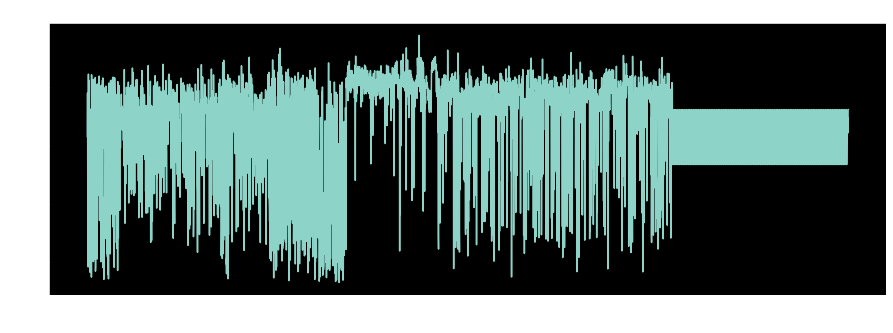

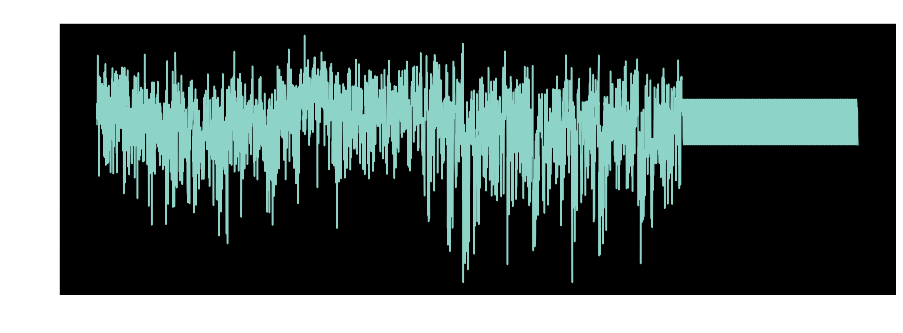

In [9]:
ITERATIONS_COUNT = 1

INITIAL_EPOCHS_COUNT = 30
EPOCHS_COUNT = 1
DATASET_SHARE = 1

TOP_SIZE = 10
SAMPLE_REPETITIONS_COUNT = 100

SHOTS_COUNT = 100
PENALTY_VALUE = 10
MAXIMIZE = False

ORTOOLS_TIME_LIMIT = 10

total_iterations_count = total_iteration + ITERATIONS_COUNT


for iteration in range(ITERATIONS_COUNT):
    
    total_iteration += 1
    
    print(f"Iteration {total_iteration}/{total_iterations_count}")
    
    splitter = Splitter(target_dataset, batch_size=100, dataloader_workers_count=8,
                        dataset_share=DATASET_SHARE)
    
    print("splitter.lengths:", splitter.lengths)

    trainer = Trainer(splitter=splitter, embedding_dimensions=16,
                      model=trainer.model,
                      optimizer=trainer.optimizer)
       
    epochs_count = INITIAL_EPOCHS_COUNT if total_iteration == 1 else EPOCHS_COUNT
    
    trainer.fit(epochs=epochs_count, validate=False, test=True,
                disable_progressbar_printout=False)

    qubo = PortfolioQubo(trainer=trainer,
                         penalty_value=PENALTY_VALUE,
                         maximize=MAXIMIZE)    

    sampling_results = sampler.sample_qubo(Q=qubo.qubo_coefficients, 
                                           num_reads=SHOTS_COUNT,
                                           time_limit=ORTOOLS_TIME_LIMIT)
    
    aggregated_results = sampling_results.aggregate()

    filtered_results = aggregated_results.filter(pred=qubo.is_correct_one_hot)
    
    results = decode_sampling_results(filtered_results)
    

    
    # Top results
    
    top_results = results.sort_values(by='binding_energy', ascending=True)[:TOP_SIZE]
    
    new_fields = np.vstack(top_results['bits'].to_numpy())
    new_targets = top_results['target_binding_energy'].to_numpy()
    

    # Append to Dataset
    
    target_dataset.append_records(new_fields, new_targets, SAMPLE_REPETITIONS_COUNT)
    
    
    # Energy Dynamics

    min_energy = new_targets.min()    
    mean_energy = new_targets.mean()
    max_energy = new_targets.max()
    
    energy_mins.append(min_energy)    
    energy_means.append(mean_energy)
    energy_maxs.append(max_energy)
    
    new_offtarget_binding_energies = np.tile(top_results['offtarget_binding_energy'], 
                                             (SAMPLE_REPETITIONS_COUNT, 1))
    
    offtarget_binding_energies = np.append(offtarget_binding_energies, new_offtarget_binding_energies)

    print(f"new_targets.min(): {new_targets.min():.02f}")
    print(f"dataset.targets.min(): {dataset.targets.min():.02f}")
    print(f"initial_dataset_energies.min(): {initial_dataset_energies.min():.02f}")
    print()
    
    if min_energy == mean_energy == max_energy:
        
        print("Converged:", mean_energy)
        break
        
# Plots

plt.figure(figsize=(15, 5))
plt.title("FMQA - Target Binding Energies")
plt.xlabel("Peptide")
plt.ylabel("Target Binding Energy")

plt.plot(target_dataset.targets)
plt.show()

plt.figure(figsize=(15, 5))
plt.title("FMQA - Offtarget Binding Energies")
plt.xlabel("Peptide")
plt.ylabel("Offtarget Binding Energy")

plt.plot(offtarget_binding_energies)
plt.show()

In [31]:
results.head(1)

,decimal,samples,bits,symbols,qubo_energy,num_occurrences,target_binding_energy,offtarget_binding_energy,binding_energy
0,2.545205023002197e+30,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",ADAKAAKAAAAAAAADAAAAAA,-1110.955963,1,-10.858204,-9.980733,-0.877471


In [17]:
# # Save Plot

# plt.figure(figsize=(15, 5))
# plt.title("FMQA - Dynamic Dataset")
# plt.xlabel("Peptide")
# plt.ylabel("Binding Energy")

# plt.plot(dataset.targets)
# plt.savefig('figures/proteins_fmqa_3.png');

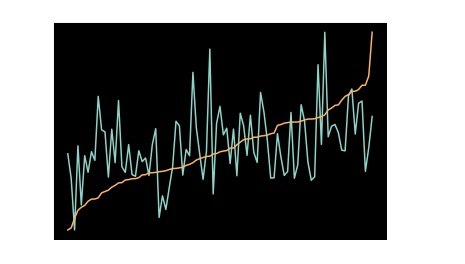

In [18]:
# Plot Top Sample Energies

plt.plot(results.binding_energy)
plt.title('Top Sample Energies')
plt.ylabel('Binding Energy')

qubo_energy_ax = plt.twinx()
qubo_energy_ax.plot(results.qubo_energy, c='C5')
qubo_energy_ax.set_ylabel('QUBO Energy')

plt.show()

### 3) ORTools Sampler 

In [64]:
from ortools.sat.python import cp_model

In [65]:
# Alt Model

model = cp_model.CpModel()
model.SetName('QUBO CP-SAT Model')

variables_count = qubo.coupling_matrix.shape[0]

variable_indices = list(range(variables_count))

variables = [model.NewBoolVar(f'linear_{index}') 
             for index in variable_indices]

objective_variables = []
objective_coefficients = []

for (i, j), coefficient in qubo.qubo_coefficients.items():
    
    if coefficient == 0.0:
        continue
        
    if i == j:
        
        variable = variables[i]
        
    else:
        
        variable = model.NewBoolVar(f'quadratic_{i}_{j}')
        
        model.AddBoolOr([variables[i].Not(), 
                         variables[j].Not(), 
                         variable])
        model.AddImplication(variable, variables[i])
        model.AddImplication(variable, variables[j])        
        
    objective_variables.append(variable)
    objective_coefficients.append(coefficient)
    

model.Minimize(sum(objective_variables[i] * objective_coefficients[i]
                   for i in range(len(objective_variables))))

print(model.ModelStats())

optimization model 'QUBO CP-SAT Model':
#Variables: 23932 (#bools:23932 in floating point objective)
  - 23932 Booleans in [0,1]
#kBoolOr: 71136 (#enforced: 47424) (#literals: 118560)


In [66]:
class SolutionCollector(cp_model.CpSolverSolutionCallback):

    def __init__(self, variables):
        
        super().__init__()
        
        self.__variables = variables
        self.solutions = []
        self.energies = []

    def on_solution_callback(self):
        
        # print([v.Name() for v in variables])
        # print(list(map(self.Value, variables)))
        
        solution = list(map(self.Value, self.__variables))        
        energy = self.ObjectiveValue()
    
        self.solutions.append(solution)
        self.energies.append(energy)

In [72]:
### Solve model

solver = cp_model.CpSolver()
solver.parameters.num_search_workers = 16
# solver.parameters.log_search_progress = True

solver.parameters.max_time_in_seconds = 10.0

collector = SolutionCollector(variables)

status = solver.Solve(model, collector)

# status = solver.Solve(model)

# Statistics

print()
print('Statistics:')
print(f'  status   : {solver.StatusName(status)}')
print(f'  conflicts: {solver.NumConflicts()}')
print(f'  branches : {solver.NumBranches()}')
print(f'  wall time: {solver.WallTime()} s')


Statistics:
  status   : FEASIBLE
  conflicts: 0
  branches : 37056
  wall time: 10.192876843 s


In [68]:
solutions = np.array(collector.solutions)

solutions[-1], collector.energies[-1], solutions.shape

(array([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0]),
 -1110.7305543720722,
 (39, 220))

In [69]:
samples = dimod.SampleSet.from_samples([{0: 10, 1: 11},
                              {0: 20, 1: 21}], 
                             energy=[[100, 200]],
                             num_occurrences=[[1000, 2000]],
                             vartype='BINARY')

for sample in samples.data():
    
    print(sample)

Sample(sample={0: 10, 1: 11}, energy=100, num_occurrences=1000)
Sample(sample={0: 20, 1: 21}, energy=200, num_occurrences=2000)


In [70]:
cp_samples = dimod.SampleSet.from_samples(
    solutions,
    energy=collector.energies,
    vartype='BINARY'
)

for sample in cp_samples.data():
    
    print(sample)
    
    break

Sample(sample={0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 1, 15: 0, 16: 0, 17: 1, 18: 0, 19: 1, 20: 0, 21: 1, 22: 0, 23: 1, 24: 0, 25: 1, 26: 0, 27: 1, 28: 1, 29: 0, 30: 1, 31: 0, 32: 0, 33: 1, 34: 1, 35: 0, 36: 0, 37: 1, 38: 0, 39: 1, 40: 0, 41: 1, 42: 0, 43: 1, 44: 0, 45: 1, 46: 0, 47: 1, 48: 0, 49: 1, 50: 1, 51: 0, 52: 0, 53: 1, 54: 0, 55: 1, 56: 0, 57: 1, 58: 0, 59: 1, 60: 0, 61: 1, 62: 0, 63: 1, 64: 0, 65: 1, 66: 0, 67: 1, 68: 0, 69: 1, 70: 0, 71: 1, 72: 0, 73: 1, 74: 0, 75: 1, 76: 0, 77: 1, 78: 0, 79: 1, 80: 0, 81: 1, 82: 1, 83: 0, 84: 0, 85: 1, 86: 0, 87: 1, 88: 0, 89: 1, 90: 0, 91: 1, 92: 0, 93: 1, 94: 0, 95: 1, 96: 0, 97: 1, 98: 0, 99: 1, 100: 0, 101: 1, 102: 1, 103: 0, 104: 0, 105: 1, 106: 0, 107: 1, 108: 1, 109: 0, 110: 0, 111: 1, 112: 0, 113: 1, 114: 0, 115: 1, 116: 1, 117: 0, 118: 0, 119: 1, 120: 0, 121: 1, 122: 1, 123: 0, 124: 1, 125: 0, 126: 1, 127: 0, 128: 0, 129: 1, 130: 0, 131: 1, 132: 0, 133: 1, 134: 0, 135: 1, 136: 0,